In [8]:
# Dependencies
import os
import pathlib
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.stats as stats
from uszipcode import SearchEngine


# Import the API key
from config import geoapify_key


DATA CLEANUP

1. The first set of data was obtained from the OpenBreweryAPI. The API is a free API, however it limits the number of queries to 200 rows and restricting sourcing of data to 2 pages at a time. In order to source all necessary data, it was necessary to create a loop to move through all 156 pages of the API and collect 100 cases per page or 200 every two pages. 

In [3]:
# URL for GET requests to retrieve brewery data
base_url = 'https://api.openbrewerydb.org/v1/breweries?by_country=United_States'


# Define an empty list to fetch the page data for each set of data
brewery_data = []

# Loop through the pages to get all the data
for page in range(1, 156):
    query_url = base_url + "&page="+ str(page) + "&per_page=200"
    response = requests.get(query_url).json()
    brewery_data.append(response)

# Create a list of all the breweries
breweries = []
for page in brewery_data:
    for brewery in page:
        breweries.append(brewery)

# Create a dataframe from the list of breweries
breweries_df = pd.DataFrame(breweries)

breweries_df.head()


,id,name,brewery_type,address_1,address_2,address_3,city,state_province,postal_code,country,longitude,latitude,phone,website_url,state,street
0,5128df48-79fc-4f0f-8b52-d06be54d0cec,(405) Brewing Co,micro,1716 Topeka St,None,None,Norman,Oklahoma,73069-8224,United States,-97.46818222,35.25738891,4058160490,http://www.405brewing.com,Oklahoma,1716 Topeka St
1,9c5a66c8-cc13-416f-a5d9-0a769c87d318,(512) Brewing Co,micro,407 Radam Ln Ste F200,None,None,Austin,Texas,78745-1197,United States,None,None,5129211545,http://www.512brewing.com,Texas,407 Radam Ln Ste F200
2,ef970757-fe42-416f-931d-722451f1f59c,10 Barrel Brewing Co,large,1501 E St,None,None,San Diego,California,92101-6618,United States,-117.129593,32.714813,6195782311,http://10barrel.com,California,1501 E St
3,6d14b220-8926-4521-8d19-b98a2d6ec3db,10 Barrel Brewing Co,large,62970 18th St,None,None,Bend,Oregon,97701-9847,United States,-121.281706,44.08683531,5415851007,http://www.10barrel.com,Oregon,62970 18th St
4,e2e78bd8-80ff-4a61-a65c-3bfbd9d76ce2,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,None,None,Bend,Oregon,97703-2465,United States,-121.3288021,44.0575649,5415851007,None,Oregon,1135 NW Galveston Ave Ste B


It can be seen right away that the dataframe might be missing some values - the most importantly latitude and longitue which was important for maping visualizations. 

The describe function below shows that 2,392 rows are misisng the longitude and latitude. Since the number of rows consitutde 30% of the full data set, 
it was important to backfull the missing information.   

In [6]:
#creates a summary table of the data
breweries_df.describe()

,id,name,brewery_type,address_1,address_2,address_3,city,state_province,postal_code,country,longitude,latitude,phone,website_url,state,street
count,7936,7936,7936,7153,4,0,7936,7936,7936,7936,5544,5544,7141,6787,7936,7153
unique,7936,7791,10,7064,4,0,2908,54,7695,2,5433,5433,6950,6437,54,7064
top,5128df48-79fc-4f0f-8b52-d06be54d0cec,Granite City Food & Brewery,micro,303 Main St,Estacada,NaN,Portland,California,64108,United States,-112.0773456,33.4485866,5122442739,http://www.gcfb.net,California,303 Main St
freq,1,6,4115,3,1,NaN,105,912,5,7935,6,6,5,23,912,3


In [7]:
#Prepare the breweries Database for analysis 
#drop brevery id, address_2, address_3, country, phone, website_url, and street
clean_breweries_df = breweries_df.drop(columns=['id', 'address_2', 'address_3', 'country', 'phone', 'website_url', 'street'])
clean_breweries_df.head()

,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state
0,(405) Brewing Co,micro,1716 Topeka St,Norman,Oklahoma,73069-8224,-97.46818222,35.25738891,Oklahoma
1,(512) Brewing Co,micro,407 Radam Ln Ste F200,Austin,Texas,78745-1197,None,None,Texas
2,10 Barrel Brewing Co,large,1501 E St,San Diego,California,92101-6618,-117.129593,32.714813,California
3,10 Barrel Brewing Co,large,62970 18th St,Bend,Oregon,97701-9847,-121.281706,44.08683531,Oregon
4,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,Bend,Oregon,97703-2465,-121.3288021,44.0575649,Oregon


Here's further confirmation that the necessary longtidue and latitude info is misisng in large numbers.   

In [8]:
#count missing values for each column
clean_breweries_df.isnull()
#count missing values for each column 
clean_breweries_df.isnull().sum()

# TEAM: We need to decide how to handle the missing values.  Do we drop the rows?

name                 0
brewery_type         0
address_1          783
city                 0
state_province       0
postal_code          0
longitude         2392
latitude          2392
state                0
dtype: int64

Decided to use Geopify to pull latitude and longtiude for the missing zip codes. Since Geopify did not recognize the postal code +4 format; 
opted to use the uszipcode package to extract the first 5 digits. While long/lat can be also pulled via uszipcode package, the exercise was to demonstrate the use of API for sourcing additional information. Using the package will also allow pulling additional information later.  

In [23]:
#create a new column in dataframe with first 5 digits of zip code ensuring the information is stored as stings & recognized as zipcodes.

search = SearchEngine()

def extract_zipcode(zipcode):
    # Remove +4 extension if present
    zipcode = zipcode.split('-')[0]
    zipcode_obj = search.by_zipcode(zipcode)
    if zipcode_obj is not None:
        return str(zipcode_obj.zipcode)[:5].zfill(5)
    else:
        return None

clean_breweries_df['zip_code'] = clean_breweries_df['postal_code'].apply(extract_zipcode).astype(str)

#add a ditinct ID number to each row 
clean_breweries_df['brewery_id'] = clean_breweries_df.index + 1
clean_breweries_df.head()


,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
0,(405) Brewing Co,micro,1716 Topeka St,Norman,Oklahoma,73069-8224,-97.46818222,35.25738891,Oklahoma,73069,1
1,(512) Brewing Co,micro,407 Radam Ln Ste F200,Austin,Texas,78745-1197,None,None,Texas,78745,2
2,10 Barrel Brewing Co,large,1501 E St,San Diego,California,92101-6618,-117.129593,32.714813,California,92101,3
3,10 Barrel Brewing Co,large,62970 18th St,Bend,Oregon,97701-9847,-121.281706,44.08683531,Oregon,97701,4
4,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,Bend,Oregon,97703-2465,-121.3288021,44.0575649,Oregon,97703,5


In [10]:

#load dataframe into csv
clean_breweries_df.to_csv('breweries.csv', index=False)
#show count by the length of the postal code to see if there are any invalid postal codes
clean_breweries_df['zip_code'].str.len().value_counts()

5    7929
4       7
Name: zip_code, dtype: int64

In [11]:
#use dataframe from the csv breveries.csv
input_path = os.path.join("breweries.csv")
csv_breweries_df = pd.read_csv(input_path)

In [12]:
#Quick test if the API request url worked for a specific zip code
#postcode = "78745"
#target_url = f"https://api.geoapify.com/v1/geocode/autocomplete?text={postcode}&limit=1&type=postcode&format=json&apiKey={geoapify_key}"
#response = requests.get(target_url).json()
#print(json.dumps(response, indent=4, sort_keys=True))


Creating a dataframe with missing information to temporarily separate from the clean of the data.

In [13]:
#extract rows with missing longitude and create a new dataframe - all longitude missing values correspond to missinging latitude values
missing_long_df = csv_breweries_df[csv_breweries_df['longitude'].isnull()]

#create a new dataframe with only the missing longitude rowsbased on clean_breweries_df
missing_long_df = clean_breweries_df[clean_breweries_df['longitude'].isnull()]

missing_long_df.head()


,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
1,(512) Brewing Co,micro,407 Radam Ln Ste F200,Austin,Texas,78745-1197,None,None,Texas,78745,2
18,12 Gates Brewing Company,brewpub,80 Earhart Dr Ste 20,Williamsville,New York,14221-7804,None,None,New York,14221,19
19,12 West Brewing Company,micro,3000 E Ray Rd Bldg 6,Gilbert,Arizona,85296-7832,None,None,Arizona,85296,20
24,12welve Eyes Brewing,micro,141 E 4th St Ste LL2,Saint Paul,Minnesota,55101-1639,None,None,Minnesota,55101,25
26,13 Stripes Brewery,brewpub,"250 Mill St, Suite PW3101",Taylors,South Carolina,29687,None,None,South Carolina,29687,27


In [14]:
#drop the missing_long dataframe into a csv file

missing_long_df.to_csv('breweries_missing_values.csv', index=False)


In [15]:

#use dataframe from the csv_breweries_missing_values.csv
input_path2 = os.path.join("breweries_missing_values.csv")
csv_breweries_missing_df = pd.read_csv(input_path2)


Finally demonstrate use of Geopify for obtianing missing information - encountered errors were bypassed with the try/except. 

In [19]:
#for missing longitude, use geopify to look up the longitude and latitude
for index, row in csv_breweries_missing_df.iterrows():
    postcode = row['zip_code']
    target_url = f"https://api.geoapify.com/v1/geocode/autocomplete?text={postcode}&limit=1&type=postcode&format=json&apiKey={geoapify_key}"
    response = requests.get(target_url)

    try:
        json_response = json.loads(response.text)
        if json_response:
            csv_breweries_missing_df.loc[index, 'longitude'] = json_response['results'][0]['lon']
            csv_breweries_missing_df.loc[index, 'latitude'] = json_response['results'][0]['lat']
            print(f"index: {index}, postcode: {postcode}, longitude: {json_response['results'][0]['lon']}, latitude: {json_response['results'][0]['lat']}") 

        else:
            print(f"Error: Empty JSON response for index {index}, postcode {postcode}")
    except IndexError:
        print(f"Error: IndexError occurred for index {index}, postcode {postcode}")
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON response for index {index}, postcode {postcode}")

csv_breweries_missing_df.head()

index: 0, postcode: 78745, longitude: -97.792614846, latitude: 30.208605656
index: 1, postcode: 14221, longitude: -78.729920877, latitude: 42.980952841
index: 2, postcode: 85296, longitude: -111.762518433, latitude: 33.335136701
index: 3, postcode: 55101, longitude: -93.088300242, latitude: 44.955919207
index: 4, postcode: 29687, longitude: -82.327800669, latitude: 34.991467109
index: 5, postcode: 27603, longitude: -78.66089377, latitude: 35.71301003
index: 6, postcode: 56442, longitude: -94.116315338, latitude: 46.677860236
index: 7, postcode: 05478, longitude: -73.104390267, latitude: 44.803484605
index: 8, postcode: 21157, longitude: -76.983937143, latitude: 39.558197671
index: 9, postcode: 22553, longitude: -77.60125509, latitude: 38.231176411
index: 10, postcode: 11741, longitude: -73.070358674, latitude: 40.794962148
index: 11, postcode: 05452, longitude: -73.08637315, latitude: 44.51595767
index: 12, postcode: 20109, longitude: -77.506105128, latitude: 38.784153209
index: 13, po

,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
0,(512) Brewing Co,micro,407 Radam Ln Ste F200,Austin,Texas,78745-1197,-97.792615,30.208606,Texas,78745,2
1,12 Gates Brewing Company,brewpub,80 Earhart Dr Ste 20,Williamsville,New York,14221-7804,-78.729921,42.980953,New York,14221,19
2,12 West Brewing Company,micro,3000 E Ray Rd Bldg 6,Gilbert,Arizona,85296-7832,-111.762518,33.335137,Arizona,85296,20
3,12welve Eyes Brewing,micro,141 E 4th St Ste LL2,Saint Paul,Minnesota,55101-1639,-93.088300,44.955919,Minnesota,55101,25
4,13 Stripes Brewery,brewpub,"250 Mill St, Suite PW3101",Taylors,South Carolina,29687,-82.327801,34.991467,South Carolina,29687,27


In [22]:
#save the dataframe with filled info into a csv file csv_breweries_missing_completed_df
csv_breweries_missing_df.to_csv('breweries_missing_completed.csv', index=False)
csv_breweries_missing_df.head()

,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
0,(512) Brewing Co,micro,407 Radam Ln Ste F200,Austin,Texas,78745-1197,-97.792615,30.208606,Texas,78745,2
1,12 Gates Brewing Company,brewpub,80 Earhart Dr Ste 20,Williamsville,New York,14221-7804,-78.729921,42.980953,New York,14221,19
2,12 West Brewing Company,micro,3000 E Ray Rd Bldg 6,Gilbert,Arizona,85296-7832,-111.762518,33.335137,Arizona,85296,20
3,12welve Eyes Brewing,micro,141 E 4th St Ste LL2,Saint Paul,Minnesota,55101-1639,-93.088300,44.955919,Minnesota,55101,25
4,13 Stripes Brewery,brewpub,"250 Mill St, Suite PW3101",Taylors,South Carolina,29687,-82.327801,34.991467,South Carolina,29687,27


Independednt T-test - Zip with brewery & without 

In [186]:
#source merged brewery file with zip code census data
input_path = os.path.join("merged_zip.csv")
zip_breweries = pd.read_csv(input_path)

In [187]:
#show missing values for zip_breweries
zip_breweries.isnull().sum()
#drop rows with missing 'Nonfamily households:'
zip_breweries = zip_breweries.dropna(subset=['Nonfamily households:'])
#drop rows with missing 'Median household income
zip_breweries = zip_breweries.dropna(subset=['Median Income 12 mths '])

zip_breweries.head()



,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,...,Population Density per km2,Population Density per mile2,Target population percentage,TOTAL Brew Population Age Bracket population,male_brew_age,Median Income 12 mths,Total: - white households,"Male householder, no spouse present","Female householder, no spouse present",Nonfamily households:
0,(405) Brewing Co,micro,1716 Topeka St,Norman,Oklahoma,73069-8224,-97.468182,35.257389,Oklahoma,73069,...,670,259.0,21%,10500,5478.0,28548.0,8647.0,430.0,835.0,4288.0
1,10 Barrel Brewing Co,large,1501 E St,San Diego,California,92101-6618,-117.129593,32.714813,California,92101,...,"3,091",1193.0,34%,26729,16087.0,52980.0,18181.0,141.0,439.0,13110.0
2,10 Barrel Brewing Co,large,62970 18th St,Bend,Oregon,97701-9847,-121.281706,44.086835,Oregon,97701,...,51,20.0,22%,17777,9339.0,37187.0,15310.0,827.0,1663.0,5986.0
4,10 Barrel Brewing Co,large,1411 NW Flanders St,Portland,Oregon,97209-2620,-122.685506,45.525979,Oregon,97209,...,"7,359",2841.0,29%,12082,6666.0,56084.0,10748.0,177.0,216.0,8383.0
5,10 Barrel Brewing Co - Bend Pub,large,62950 NE 18th St,Bend,Oregon,97701,-121.280954,44.091211,Oregon,97701,...,51,20.0,22%,17777,9339.0,37187.0,15310.0,827.0,1663.0,5986.0


In [188]:
zip_breweries.columns

Index(['name', 'brewery_type', 'address_1', 'city', 'state_province',
       'postal_code', 'longitude', 'latitude', 'state', 'zip_code',
       'brewery_id', 'Incomplete', 'Population  ',
       ' Population Density per km2 ', ' Population Density per mile2 ',
       ' Target population percentage  ',
       ' TOTAL Brew Population Age Bracket population  ', 'male_brew_age',
       'Median Income 12 mths ', 'Total: - white households',
       'Male householder, no spouse present',
       'Female householder, no spouse present', 'Nonfamily households:'],
      dtype='object')

In [189]:
#source full census data file 
input_path2 = os.path.join("no_brew_zip.csv")
no_brew_zip = pd.read_csv(input_path2)
#drop missing rows with "Median Income" null
no_brew_zip = no_brew_zip.dropna(subset=['Median Income'])
no_brew_zip.head()


,Geographic Area Name,Geographic,Area,Zip,City,State,Total population,TOTAL Brew Population Age Bracket population,male_brew_age,Median Income,Number of white households,"Male householder, no spouse present","Female householder, no spouse present",Nonfamily households:,density (km2),density(mil2)
132,ZCTA5 01001,ZCTA5,1001,1001.0,Agawam,MA,16984.0,6478.0,3618.0,41359.0,6189,339,650,2485,550.1,212.0
133,ZCTA5 01003,ZCTA5,1003,1003.0,Amherst,MA,13253.0,85.0,66.0,4453.0,10,0,0,0,6583.4,2542.0
134,ZCTA5 01008,ZCTA5,1008,1008.0,Blandford,MA,1317.0,382.0,212.0,44531.0,497,9,53,176,7.4,3.0
135,ZCTA5 01009,ZCTA5,1009,1009.0,Bondsville,MA,980.0,398.0,229.0,43233.0,333,26,29,143,442.8,171.0
136,ZCTA5 01010,ZCTA5,1010,1010.0,Brimfield,MA,3711.0,1302.0,813.0,42369.0,1345,27,99,436,40.6,16.0


In [190]:
no_brew_zip.columns

Index(['Geographic Area Name', 'Geographic', 'Area', 'Zip', 'City ', 'State',
       'Total population ', 'TOTAL Brew Population Age Bracket population ',
       'male_brew_age', 'Median Income', 'Number of white households',
       'Male householder, no spouse present',
       'Female householder, no spouse present', 'Nonfamily households:',
       'density (km2)', 'density(mil2)'],
      dtype='object')

INDEPENDENT T-TEST - comparison of all zip-codes to zip codes with with micro & brepub brewery locations. 

In [191]:
#drop rows from the zip_breweries with brewery that is NOT micro or pub and rename the dataframe
zip_breweries_micro = zip_breweries[zip_breweries['brewery_type'].isin(['micro', 'brewpub'])]


In [192]:
#find the mean of the median income for zip_breweries and no_brew_zip round to 2 decimal places
mean_with_breweries = round(zip_breweries_micro['Median Income 12 mths '].mean(),2)
mean_without_breweries = round(no_brew_zip['Median Income'].mean(),2)

#compute absolute difference between the two means with 2 decimal places

absolute_difference = round(abs(mean_with_breweries - mean_without_breweries),2)

print("Mean with breweries: $", mean_with_breweries)
print("Mean without breweries: $", mean_without_breweries)
print("Absolute difference: $", absolute_difference)

Mean with breweries: $ 38099.57
Mean without breweries: $ 33059.24
Absolute difference: $ 5040.33


In [193]:
zip_breweries['Median Income 12 mths '] = zip_breweries_micro['Median Income 12 mths '].astype(float)
no_brew_zip['Median Income'] = no_brew_zip['Median Income'].astype(float)
#run an independednt t-test for the median income of zip codes with breweries and zip codes without breweries
stats.ttest_ind(zip_breweries_micro['Median Income 12 mths '], no_brew_zip['Median Income'], equal_var=False)
#run an independednt t-test for the median age of zip codes with breweries and zip codes without breweries
#stats.ttest_ind(zip_breweries['Median Age'], no_brew_zip['Median Age'], equal_var=False)


Ttest_indResult(statistic=27.587155939972227, pvalue=1.0600259801014812e-160)

In [194]:
mean_difference = zip_breweries['Median Income 12 mths '].mean() - no_brew_zip['Median Income'].mean()
pooled_std = np.sqrt((zip_breweries_micro['Median Income 12 mths '].std()**2 + no_brew_zip['Median Income'].std()**2) / 2)

cohen_d = mean_difference / pooled_std

print("Cohen's d:", cohen_d)

Cohen's d: 0.3978458087054


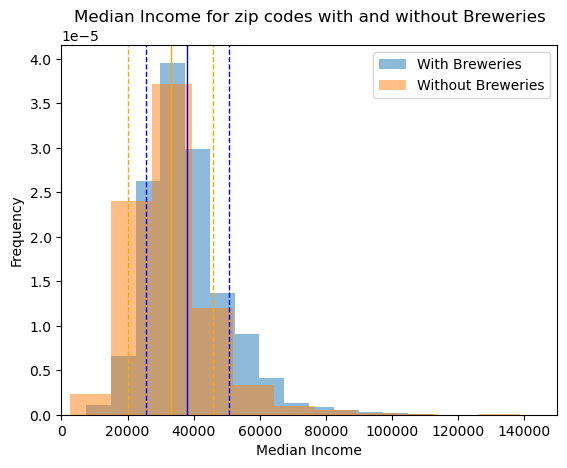

In [221]:
 # plot a histogram showing the data comparing the two populations using small markers
plt.hist(zip_breweries_micro['Median Income 12 mths '], alpha=0.5, label='With Breweries', bins=20, density=True)
plt.hist(no_brew_zip['Median Income'], alpha=0.5, label='Without Breweries', bins=20, density=True)
plt.axvline(zip_breweries_micro['Median Income 12 mths '].mean(), color='blue', linestyle='solid', linewidth=1)
plt.axvline(no_brew_zip['Median Income'].mean(), color='orange', linestyle='solid', linewidth=1)
plt.axvline(zip_breweries_micro['Median Income 12 mths '].mean() + zip_breweries_micro['Median Income 12 mths '].std(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(no_brew_zip['Median Income'].mean() + no_brew_zip['Median Income'].std(), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(zip_breweries_micro['Median Income 12 mths '].mean() - zip_breweries_micro['Median Income 12 mths '].std(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(no_brew_zip['Median Income'].mean() - no_brew_zip['Median Income'].std(), color='orange', linestyle='dashed', linewidth=1)
plt.title('Median Income for zip codes with and without Breweries')
plt.xlabel('Median Income')
plt.ylabel('Frequency')

#limit x axis to 0 to 150000
plt.xlim(0, 150000)

plt.legend()
plt.show()


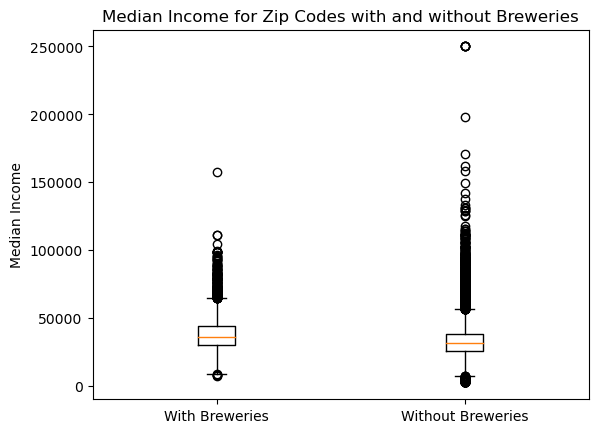

In [196]:
#plot boxplot to show the data comparing the two populations
plt.boxplot([zip_breweries_micro['Median Income 12 mths '], no_brew_zip['Median Income']], labels=['With Breweries', 'Without Breweries'])
plt.title('Median Income for Zip Codes with and without Breweries')
plt.ylabel('Median Income')
plt.show()


The results show that the difference in median income between the two datasets is statistically significant. The Cohen's d suggests that the the magnitude of the difference is considered relatively 'modest.'

__________________________________________________________________________________

T-TEST NOT Appropriate due to dataset skew - zip code 

In [197]:
#drop rows in zip_breweries_micro dataframe where male_brew_age column value is empty
zip_breweries_micro_males = zip_breweries.dropna(subset=['male_brew_age'])
no_brew_zip_males = no_brew_zip.dropna(subset=['male_brew_age'])

#find the mean of male population for zip_breweries and no_brew_zip round to 0 decimal places
mean_with_breweries_males = round(zip_breweries_micro_males['male_brew_age'].mean(),0)
mean_without_breweries_males = round(no_brew_zip_males['male_brew_age'].mean(),0)

#compute absolute difference between the two means with 2 decimal places

absolute_difference_males = round(abs(mean_with_breweries_males - mean_without_breweries_males),2)

print("Mean male median age 25-54 population for zip codes with breweries:", mean_with_breweries_males)
print("Mean male median age 25-54 population for zip codes without breweries:", mean_without_breweries_males)
print("Absolute difference:", absolute_difference_males)

Mean male median age 25-54 population for zip codes with breweries: 5831.0
Mean male median age 25-54 population for zip codes without breweries: 1588.0
Absolute difference: 4243.0


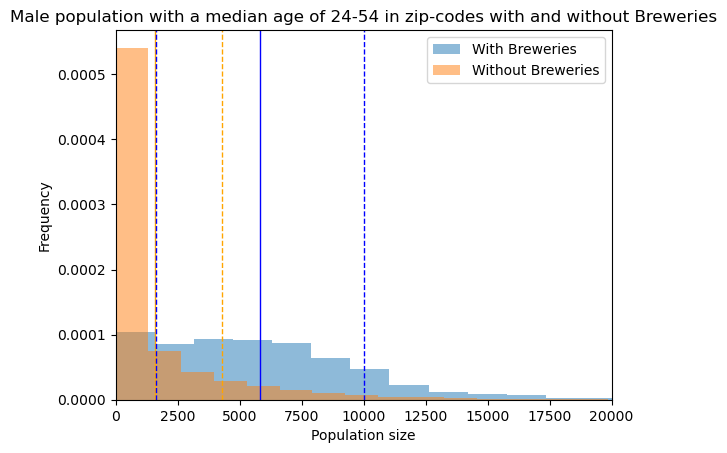

In [200]:
 # plot a histogram showing the data comparing the two populations using small markers
plt.hist(zip_breweries_micro_males['male_brew_age'], alpha=0.5, label='With Breweries', bins=20, density=True)
plt.hist(no_brew_zip_males['male_brew_age'], alpha=0.5, label='Without Breweries', bins=20, density=True)
plt.axvline(zip_breweries_micro_males['male_brew_age'].mean(), color='blue', linestyle='solid', linewidth=1)
plt.axvline(no_brew_zip_males['male_brew_age'].mean(), color='orange', linestyle='solid', linewidth=1)
plt.axvline(zip_breweries_micro_males['male_brew_age'].mean() + zip_breweries_micro_males['male_brew_age'].std(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(no_brew_zip_males['male_brew_age'].mean() + no_brew_zip_males['male_brew_age'].std(), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(zip_breweries_micro_males['male_brew_age'].mean() - zip_breweries_micro_males['male_brew_age'].std(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(no_brew_zip_males['male_brew_age'].mean() - no_brew_zip_males['male_brew_age'].std(), color='orange', linestyle='dashed', linewidth=1)
plt.title('Male population with a median age of 24-54 in zip-codes with and without Breweries')
plt.xlabel('Population size')
plt.ylabel('Frequency')

#limit x axis to 0 to 20000
plt.xlim(0, 20000)

plt.legend()
plt.show()


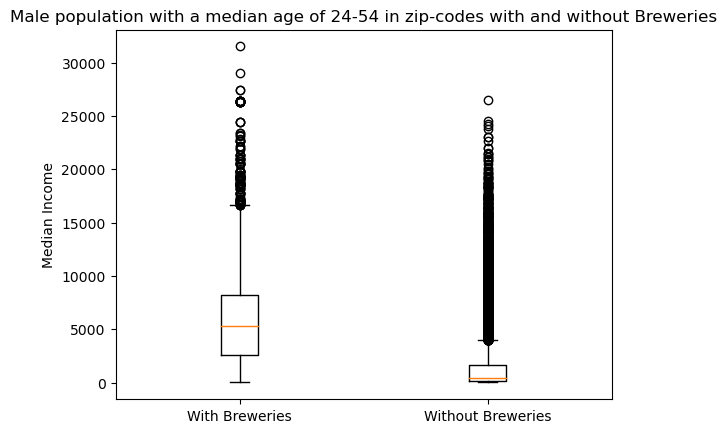

In [201]:
#plot boxplot to show the data comparing the two populations
plt.boxplot([zip_breweries_micro_males['male_brew_age'], no_brew_zip_males['male_brew_age']], labels=['With Breweries', 'Without Breweries'])
plt.title('Male population with a median age of 24-54 in zip-codes with and without Breweries')
plt.ylabel('Median Income')
plt.show()

_____________________________________________________________________________________

INDEPENDENT T-TEST NOT apporpriate due to distribution skew

In [207]:
#drop rows in zip_breweries_micro dataframe where denisty per sq mile column value is empty

zip_breweries_micro_density = zip_breweries.dropna(subset=[' Population Density per mile2 '])

no_brew_zip_density = no_brew_zip.dropna(subset=['density(mil2)'])

#find the mean of male population for zip_breweries and no_brew_zip round to 0 decimal places
mean_with_breweries_density = round(zip_breweries_micro_density[' Population Density per mile2 '].mean(),0)
mean_without_breweries_density = round(no_brew_zip_density['density(mil2)'].mean(),0)

#compute absolute difference between the two means with 2 decimal places

absolute_difference_density = round(abs(mean_with_breweries_density - mean_without_breweries_density),2)

print("Mean population density per square mile in zip codes with breweries:", mean_with_breweries_density)
print("Mean population density per square mile in zip codes without breweries:", mean_without_breweries_density)
print("Absolute difference:", absolute_difference_density)

Mean population density per square mile in zip codes with breweries: 455.0
Mean population density per square mile in zip codes without breweries: 168.0
Absolute difference: 287.0


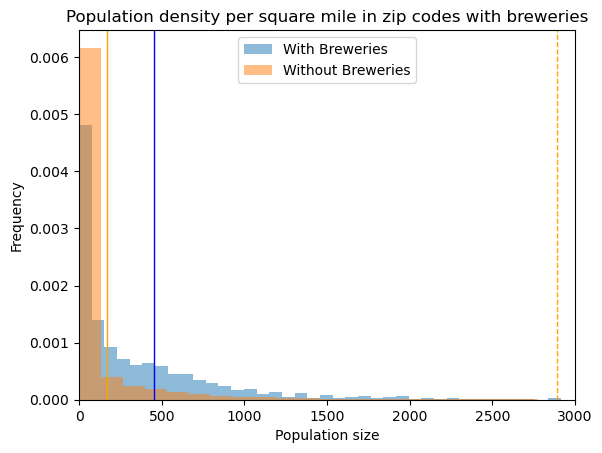

In [219]:
 # plot a histogram showing the data comparing the two populations using small markers
plt.hist(zip_breweries_micro_density[' Population Density per mile2 '], alpha=0.5, label='With Breweries', bins=200, density=True)
plt.hist(no_brew_zip_density['density(mil2)'], alpha=0.5, label='Without Breweries', bins=200, density=True)
plt.axvline(zip_breweries_micro_density[' Population Density per mile2 '].mean(), color='blue', linestyle='solid', linewidth=1)
plt.axvline(no_brew_zip_density['density(mil2)'].mean(), color='orange', linestyle='solid', linewidth=1)
plt.axvline(zip_breweries_micro_density[' Population Density per mile2 '].mean() + zip_breweries_micro_density['male_brew_age'].std(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(no_brew_zip_density['density(mil2)'].mean() + no_brew_zip_males['male_brew_age'].std(), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(zip_breweries_micro_density[' Population Density per mile2 '].mean() - zip_breweries_micro_density['male_brew_age'].std(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(no_brew_zip_density['density(mil2)'].mean() - no_brew_zip_density['male_brew_age'].std(), color='orange', linestyle='dashed', linewidth=1)
plt.title('Population density per square mile in zip codes with breweries')
plt.xlabel('Population size')
plt.ylabel('Frequency')

#limit x axis to 0 to 20000
plt.xlim(0, 3000)

plt.legend()
plt.show()


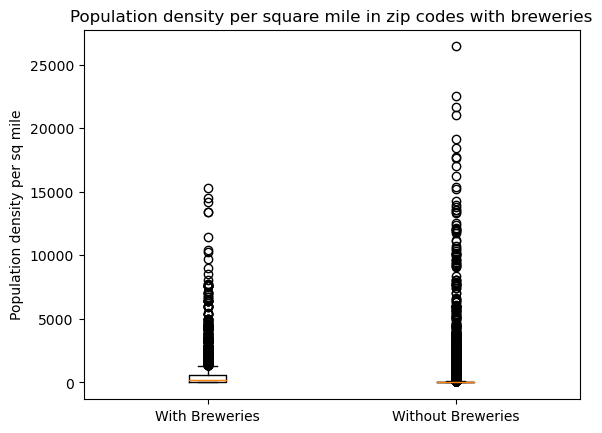

In [220]:
#plot boxplot to show the data comparing the two populations
plt.boxplot([zip_breweries_micro_density[' Population Density per mile2 '], no_brew_zip_density['density(mil2)']], labels=['With Breweries', 'Without Breweries'])
plt.title('Population density per square mile in zip codes with breweries')
plt.ylabel('Population density per sq mile')
plt.show()

LOGISTIC Regression attempt

In [224]:
#preapre logistic regression to show the relationship between the presence of breweries and the median income, male population, and population density of zip codes
import statsmodels.api as sm

#add a column to zip_breweries_micro dataframe to indicate the presence of breweries
zip_breweries_micro['breweries'] = 1

#add a column to no_brew_zip dataframe to indicate the absence of breweries
no_brew_zip['breweries'] = 0

#combine the two dataframes
zip_breweries_micro = zip_breweries_micro.append(no_brew_zip)

#drop rows in zip_breweries_micro dataframe where median income column value is empty

zip_breweries_micro_income = zip_breweries_micro.dropna(subset=['median_income'])

zip_breweries_micro_income.head()


C:\Users\lasot\AppData\Local\Temp\ipykernel_4500\207788859.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  zip_breweries_micro = zip_breweries_micro.append(no_brew_zip)


KeyError: ['median_income']

In [ ]:
X = zip_breweries_micro_income[['median_income', 'male_population', 'population_density']]
y = zip_breweries_micro_income['breweries']

logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())


#The summary will provide information about the coefficients, standard errors, p-values, and other relevant statistics for each predictor variable.

INDEPENDENT T-TEST - comparison of a random 200 brewpub/micro of open breweries against the closed locations

Because the brewery dataset is very large and consists of over 7,000 rows, in order to check the difference between the two sets a smaller random set seems like a better solution. 

In [203]:
#to limit issues with selection I opted for choosing the random 200 / wanting to avoid bias 
#decided to use a loop to run the suample multiple times 
#pick a random sample of 200 breweries from the zip_breweries_micro dataframe 
zip_breweries_micro_sample = zip_breweries_micro.sample(n=200, random_state=5)

# Assuming your large dataset is stored in a DataFrame called 'zip_breweries_micro_sample'
sample_size = 200  # Define the desired sample size
num_samples = 1000  # Define the number of random samples to take

sample_means = []  # To store the means of each random sample

for _ in range(num_samples):
    random_sample = zip_breweries_micro_sample.sample(n=sample_size, replace=True)
    sample_mean = random_sample['Median Income 12 mths '].mean()  # Calculate the mean of the column of interest
    sample_means.append(sample_mean)

average_mean_open = np.mean(sample_means)  # Calculate the average of the sample means

print("Average Mean:", average_mean_open)


Average Mean: 37361.69896


In [204]:
#extract from brewery zip data frame brewery_type = closed and create a new dataframe
zip_breweries_micro_closed = zip_breweries[zip_breweries['brewery_type'] == 'closed']
#drop rows with missing medinan income from zip_breweries_micro_closed
zip_breweries_micro_closed = zip_breweries.dropna(subset=['Median Income 12 mths '])


In [205]:
#first find the mean of the median income for the two groups to learn differences between the two absolute values

mean_closed_breweries = round(zip_breweries_micro_closed['Median Income 12 mths '].mean(),2)

#compute absolute difference between the two means with 2 decimal places

absolute_difference2 = round(abs(average_mean_open - mean_closed_breweries),2)

print("Mean for open breweries: $", average_mean_open)
print("Mean for closed breweries: $", mean_closed_breweries)
print("Absolute difference: $", absolute_difference2)

Mean for open breweries: $ 37361.69896
Mean for closed breweries: $ 38099.57
Absolute difference: $ 737.87


In [206]:
#run an independednt t-test for the median income of zip codes were breweries closed
#stats.ttest_ind(zip_breweries_micro_closed['Median Income 12 mths '], average_mean_open, equal_var=False)